# Seoul Bike Sharing Demand
https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from autogluon.tabular import TabularDataset, TabularPredictor

### Dataset

In [2]:
data = pd.read_excel('../../data/seoul+bike+sharing+demand.xlsx')
target_variable = 'Rented Bike Count'
print(data.shape)
data.head()

(8760, 14)


,Date,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12 00:00:00,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12 00:00:00,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12 00:00:00,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12 00:00:00,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12 00:00:00,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Hour                       8760 non-null   int64  
 2   Rented Bike Count          8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [4]:
# add hours to the date tiem field
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = pd.to_datetime(dict(year=data['Date'].dt.year, month=data['Date'].dt.month, day=data['Date'].dt.day, hour=data['Hour']))
data['year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day_of_week
cols_to_convert = ['Humidity(%)', 'Visibility (10m)']
data[cols_to_convert] = data[cols_to_convert].astype('float')
data[['Seasons', 'Holiday', 'Functioning Day']] = data[['Seasons', 'Holiday', 'Functioning Day']].astype('category')
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-12 00:00:00 to 2018-11-30 23:00:00
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Hour                       8760 non-null   int64   
 1   Rented Bike Count          8760 non-null   int64   
 2   Temperature(°C)            8760 non-null   float64 
 3   Humidity(%)                8760 non-null   float64 
 4   Wind speed (m/s)           8760 non-null   float64 
 5   Visibility (10m)           8760 non-null   float64 
 6   Dew point temperature(°C)  8760 non-null   float64 
 7   Solar Radiation (MJ/m2)    8760 non-null   float64 
 8   Rainfall(mm)               8760 non-null   float64 
 9   Snowfall (cm)              8760 non-null   float64 
 10  Seasons                    8760 non-null   category
 11  Holiday                    8760 non-null   category
 12  Functioning Day            8760 non-null   category
 1

C:\Users\okmic\AppData\Local\Temp\ipykernel_14616\1705704574.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [5]:
data.describe()

,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),year,Month,Day
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,2017.915068,6.526027,3.021918
std,6.922582,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.278796,3.448048,1.999994
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,2017.000000,1.000000,0.000000
25%,5.750000,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,2018.000000,4.000000,1.000000
50%,11.500000,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,2018.000000,7.000000,3.000000
75%,17.250000,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,2018.000000,10.000000,5.000000
max,23.000000,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,2018.000000,12.000000,6.000000


### Some manual visualization

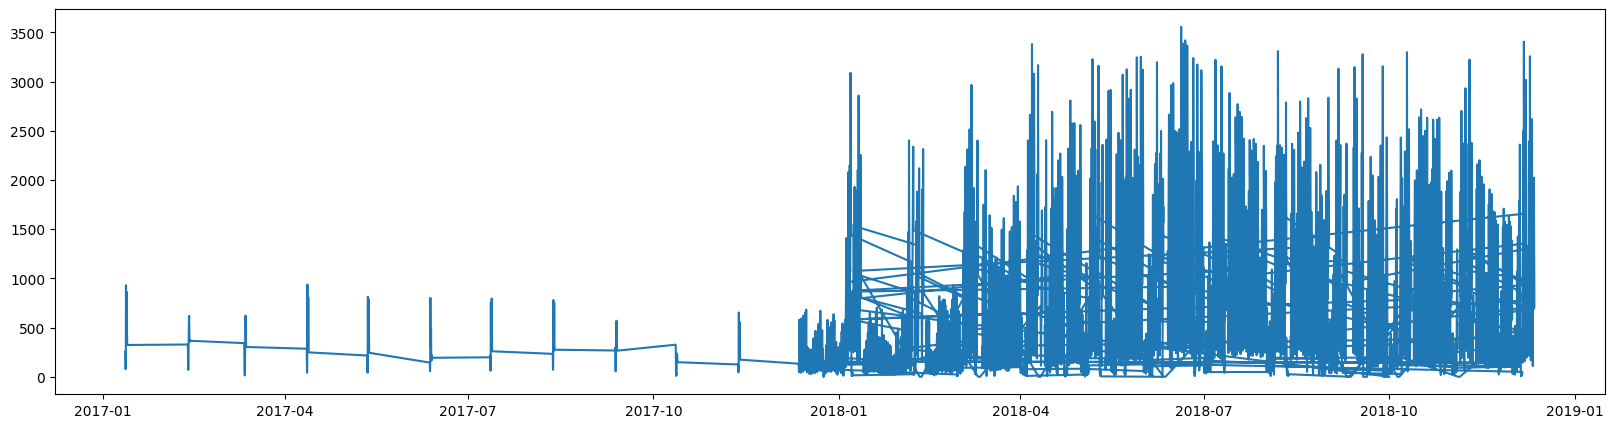

In [6]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(data.index, data[target_variable])
# sns.lineplot(data=data, x="Date", y=target_variable, ax=ax)
plt.show()

(200, 16)


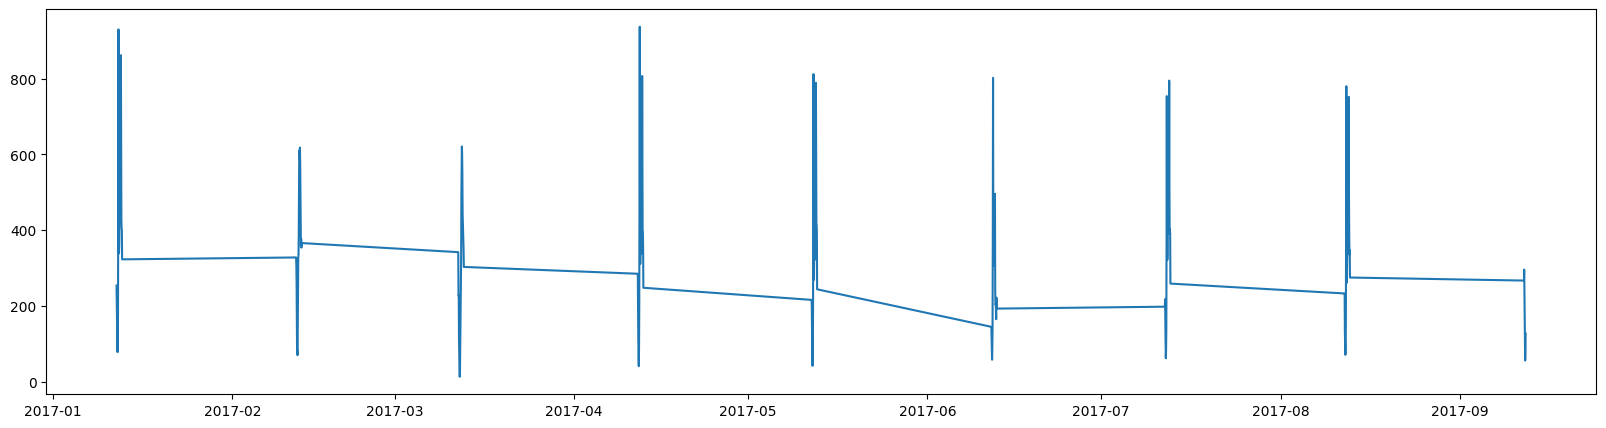

In [7]:
# smaller window of time
fig, ax = plt.subplots(figsize=(20,5))
first_months = data.iloc[:200]
print(first_months.shape)
ax.plot(first_months.index, first_months[target_variable])
plt.show()

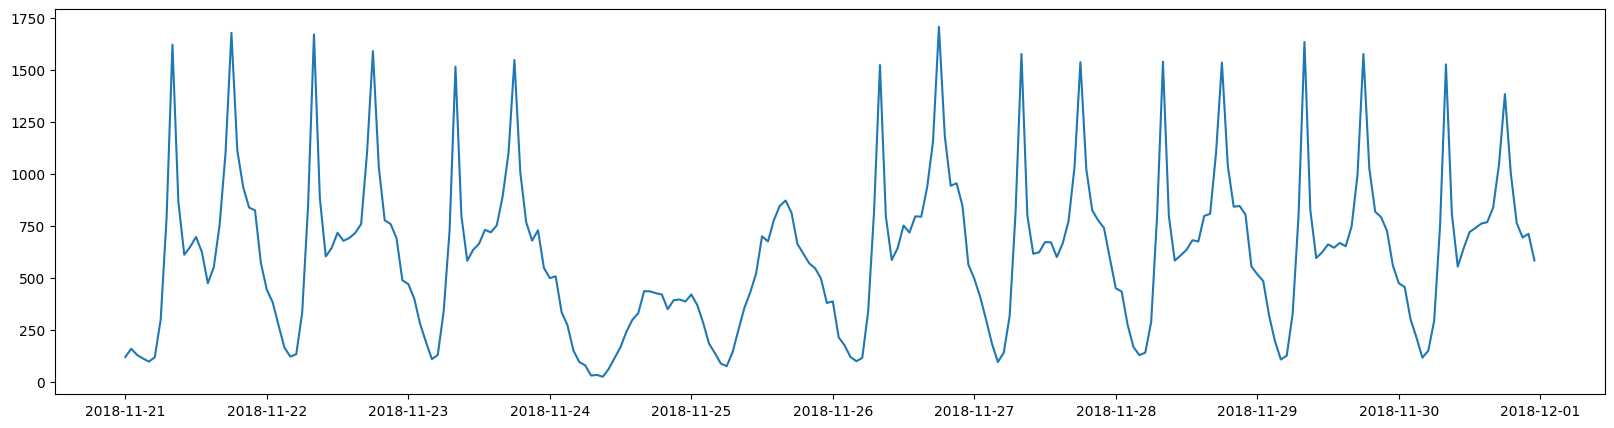

In [8]:
# smaller window of time
fig, ax = plt.subplots(figsize=(20,5))
last_5_days = data.iloc[-240:]
ax.plot(last_5_days.index, last_5_days[target_variable])
plt.show()

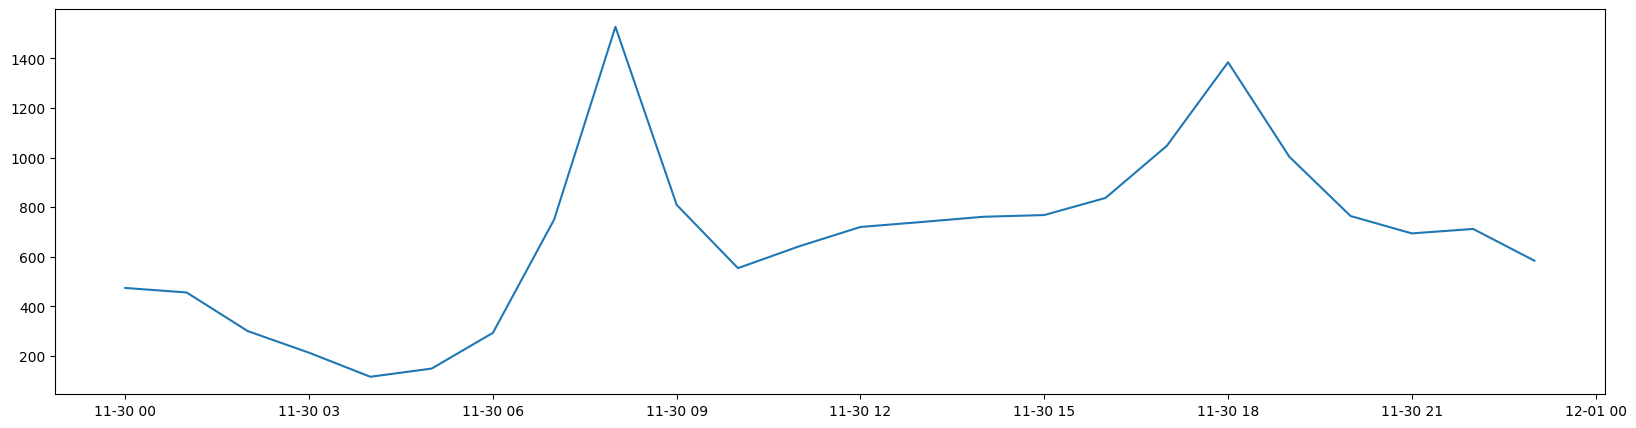

In [9]:
# even smaller window of time
fig, ax = plt.subplots(figsize=(20,5))
last_day = data.iloc[-24:]
ax.plot(last_day.index, last_day[target_variable])
plt.show()

C:\Users\okmic\.conda\envs\autogluon_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


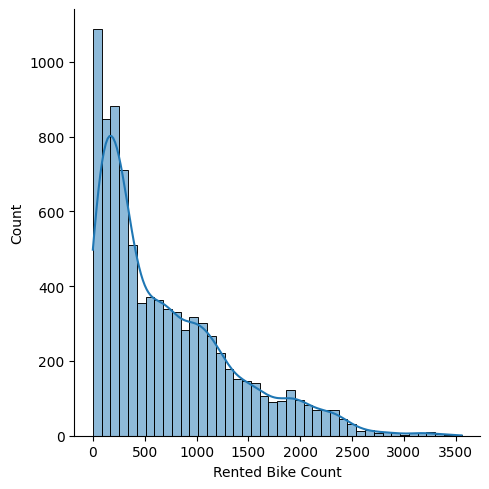

In [10]:
sns.displot(data['Rented Bike Count'], kde=True)

### Data Analysis

Check the `autoviz` folder for our data analysis on this dataset

### Dataset split

In [11]:
test_size = int(data.shape[0] * 0.2)
train_df = data.iloc[0:-test_size,]
test_df = data.iloc[-test_size:,]

X_train = train_df.drop(columns=[target_variable], axis=1)
y_train = train_df[target_variable]
X_test = test_df.drop(columns=[target_variable], axis=1)
y_test = test_df[target_variable]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7008, 15)
(7008,)
(1752, 15)
(1752,)


### AutoML training

In [12]:
def display_metrics(index, y_true, y_hat):
    print(f'Mean absolute error is {round(mean_absolute_error(y_true, y_hat), 4)}')
    print(f'Mean absolute percentage error is {round(mean_absolute_percentage_error(y_true, y_hat), 4)}')
    print(f'Mean square error is {round(mean_squared_error(y_true, y_hat), 4)}')
    print(f'Root mean square error is {round(np.sqrt(mean_squared_error(y_true, y_hat)), 4)}')
    print(f'R2 score is {round(r2_score(y_true, y_hat), 4)}')
    print('\n\n')
    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
    # plot the residual
    sns.distplot(y_true - y_hat, kde=True, ax=ax[0])

    ax[1].plot(index, y_true, color='blue')
    ax[1].plot(index, y_hat, color='red')
    ax[1].set_ylabel('Rented Bike Count')
    ax[1].set_xlabel('Date')
    ax[1].set_title('Predicted vs Actual')


In [13]:
tabular_dataset = TabularDataset.from_records(train_df)
predictor = TabularPredictor(label=target_variable, eval_metric='rmse').fit(train_data=tabular_dataset)

No path specified. Models will be saved in: "AutogluonModels\ag-20230730_180813\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230730_180813\"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   313.43 GB / 433.03 GB (72.4%)
Train Data Rows:    7008
Train Data Columns: 15
Label Column: Rented Bike Count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (3556, 0, 691.50328, 652.01721)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:   

[1000]	valid_set's rmse: 213.372
[2000]	valid_set's rmse: 204.264
[3000]	valid_set's rmse: 200.797
[4000]	valid_set's rmse: 198.251
[5000]	valid_set's rmse: 196.322
[6000]	valid_set's rmse: 195.106
[7000]	valid_set's rmse: 194.196
[8000]	valid_set's rmse: 193.768
[9000]	valid_set's rmse: 193.154
[10000]	valid_set's rmse: 192.8


	-192.7903	 = Validation score   (-root_mean_squared_error)
	9.99s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 208.995
[2000]	valid_set's rmse: 204.836
[3000]	valid_set's rmse: 203.876
[4000]	valid_set's rmse: 203.353
[5000]	valid_set's rmse: 202.909
[6000]	valid_set's rmse: 202.738
[7000]	valid_set's rmse: 202.553
[8000]	valid_set's rmse: 202.522
[9000]	valid_set's rmse: 202.505
[10000]	valid_set's rmse: 202.465


	-202.4604	 = Validation score   (-root_mean_squared_error)
	9.62s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-239.0657	 = Validation score   (-root_mean_squared_error)
	2.97s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-200.7425	 = Validation score   (-root_mean_squared_error)
	260.59s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-233.0149	 = Validation score   (-root_mean_squared_error)
	1.36s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-236.5053	 = Validation score   (-root_mean_squared_error)
	10.72s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-203.1511	 = Validation score   (-root_mean_squared_error)
	3.63s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-214.9603	 = Validation score   (-root_mean_squared_error)
	75.35s	 = Training   runtime
	0.02s	

[1000]	valid_set's rmse: 206.867
[2000]	valid_set's rmse: 205.891
[3000]	valid_set's rmse: 205.792
[4000]	valid_set's rmse: 205.767
[5000]	valid_set's rmse: 205.765
[6000]	valid_set's rmse: 205.764
[7000]	valid_set's rmse: 205.764
[8000]	valid_set's rmse: 205.764
[9000]	valid_set's rmse: 205.764
[10000]	valid_set's rmse: 205.764


	-205.7642	 = Validation score   (-root_mean_squared_error)
	25.42s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-184.5596	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 408.61s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230730_180813\")


In [14]:
predictor.leaderboard();

                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -184.559596       0.718722  114.684034                0.000000           0.296843            2       True         12
1            LightGBMXT -192.790299       0.296876    9.990987                0.296876           9.990987            1       True          3
2              CatBoost -200.742540       0.018771  260.593158                0.018771         260.593158            1       True          6
3              LightGBM -202.460430       0.234384    9.624107                0.234384           9.624107            1       True          4
4               XGBoost -203.151145       0.031249    3.629814                0.031249           3.629814            1       True          9
5         LightGBMLarge -205.764199       0.374969   25.416893                0.374969          25.416893            1       True         11
6        Neur

Computing feature importance via permutation shuffling for 15 features using 5000 rows with 5 shuffle sets...
	480.08s	= Expected runtime (96.02s per shuffle set)
	417.03s	= Actual runtime (Completed 5 of 5 shuffle sets)


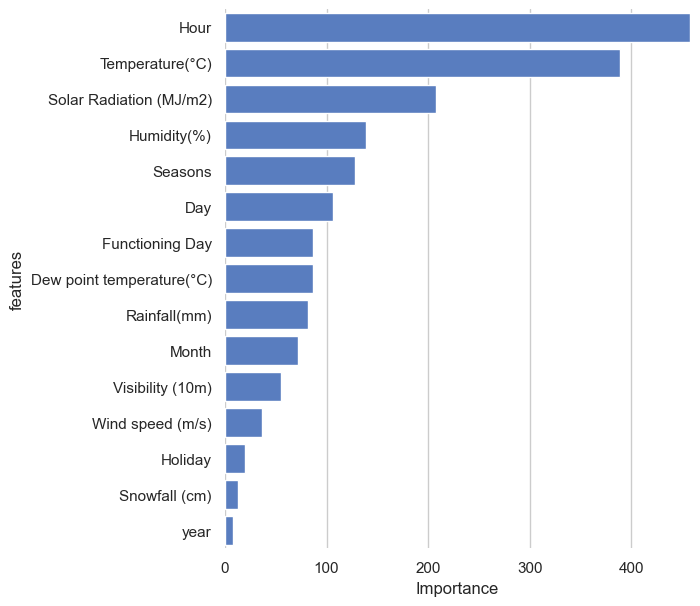

In [16]:
import matplotlib.pyplot as plt
feature_imp = predictor.feature_importance(tabular_dataset)
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 7))

# take top 30
feature_imp = feature_imp[:30]
# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(y=feature_imp.index, x=feature_imp.importance, label="Importance", color="b", ax=ax)

ax.set(xlim=(0, feature_imp.importance.max()+0.001), ylabel="features", xlabel="Importance")
sns.despine(left=True, bottom=True)

In [18]:
train_test_dataset = TabularDataset.from_records(train_df.drop(columns=[target_variable], axis=1))
y_y_train = train_df[target_variable]
train_predictions = predictor.predict(train_test_dataset)

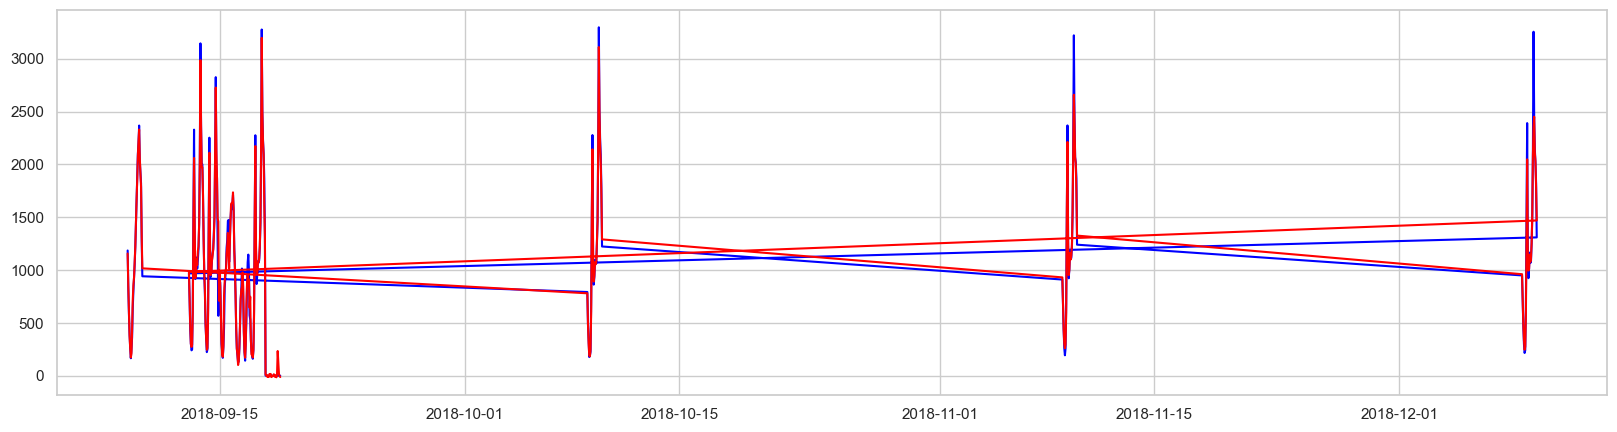

In [19]:
# smaller window of time
fig, ax = plt.subplots(figsize=(20,5))
last_5_days = y_y_train.iloc[-240:]
ax.plot(last_5_days.index, last_5_days[-240:], color='blue')
ax.plot(last_5_days.index, train_predictions[-240:], color='red')
plt.show()

### Testing and evaluation

Mean absolute error is 215.0869
Mean absolute percentage error is 7.602697066437451e+16
Mean square error is 91683.9703
Root mean square error is 302.7936
R2 score is 0.7563





C:\Users\okmic\AppData\Local\Temp\ipykernel_14616\1396220488.py:10: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  sns.distplot(y_true - y_hat, kde=True, ax=ax[0])
C:\Users\okmic\AppData\Local\Temp\ipykernel_14616\1396220488.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true - y_hat, kde=True, ax=ax[0])
C:\Users\okmic\.conda\envs\autogluon_env\lib\site-packages\seaborn\distributions.py:2479: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\okmic\.conda\envs\autogluon_env\lib\site-packages\numpy\core\_methods.py:192: Runtim

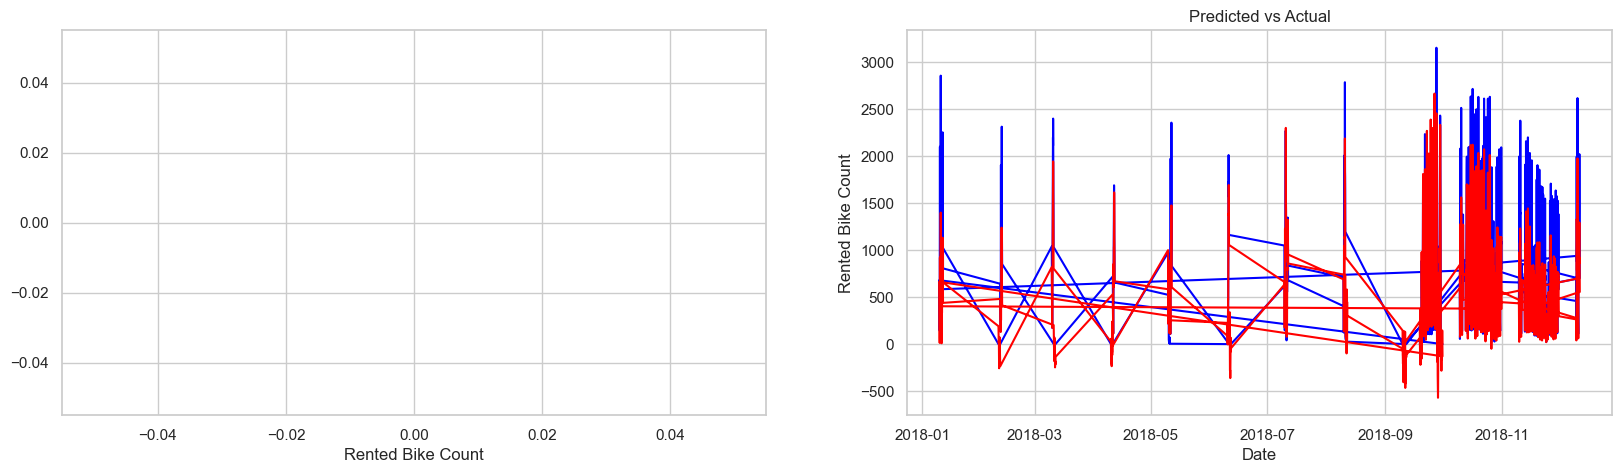

In [20]:
y_hats = predictor.predict(TabularDataset.from_records(test_df.drop(columns=[target_variable], axis=1)))
display_metrics(X_test.index, y_test, y_hats)

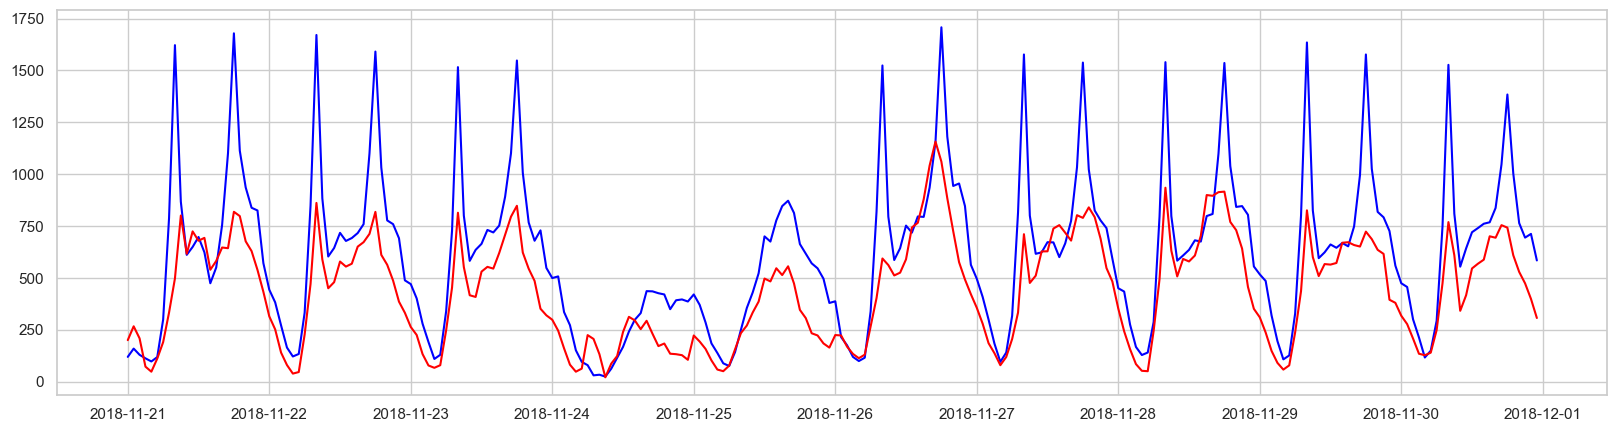

In [21]:
# smaller window of time
fig, ax = plt.subplots(figsize=(20,5))
test_5_days = y_test.iloc[-240:]
ax.plot(test_5_days.index, test_5_days[-240:], color='blue')
ax.plot(test_5_days.index, y_hats[-240:], color='red')
plt.show()